In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
N = 50
np.random.seed(0)
sa_values = np.random.uniform(0, 100, N)
s_true = 50.0
sigma = 10.0
T = 1.0
R_max = 20.0

In [ ]:
def gaussian_tuning_curve(s, sa, sigma, R_max):
    return R_max * np.exp(-0.5 * ((s - sa) / sigma)**2)
expected_rates = np.array([gaussian_tuning_curve(s_true, sa, sigma, R_max) for sa in sa_values])
r_values = np.random.poisson(expected_rates * T)

In [ ]:
def log_likelihood(s, r_values, sa_values, sigma, T, R_max):
    ll = 0.0
    for r, sa in zip(r_values, sa_values):
        f = gaussian_tuning_curve(s, sa, sigma, R_max)
        ll += r * np.log(f * T) - f * T - math.lgamma(r + 1)
    return ll

In [ ]:
def d_log_likelihood_ds(s, r_values, sa_values, sigma, T, R_max):
    grad = 0.0
    for r, sa in zip(r_values, sa_values):
        f = gaussian_tuning_curve(s, sa, sigma, R_max)
        d_f_ds = - (s - sa) / (sigma**2) * f
        grad += r * (d_f_ds / f) - T * d_f_ds
    return grad

In [ ]:
def optimize_gradient_descent(learning_rate, epochs):
    s_opt = np.mean(sa_values)
    for _ in range(epochs):
        grad = d_log_likelihood_ds(s_opt, r_values, sa_values, sigma, T, R_max)
        s_opt += learning_rate * grad
    return s_opt

In [ ]:
def optimize_momentum(learning_rate, epochs, beta=0.9):
    s_opt = np.mean(sa_values)
    velocity = 0
    for _ in range(epochs):
        grad = d_log_likelihood_ds(s_opt, r_values, sa_values, sigma, T, R_max)
        velocity = beta * velocity + (1 - beta) * grad
        s_opt += learning_rate * velocity
    return s_opt

In [ ]:
def optimize_nesterov(learning_rate, epochs, beta=0.9):
    s_opt = np.mean(sa_values)
    velocity = 0
    for _ in range(epochs):
        lookahead_s = s_opt + beta * velocity
        grad = d_log_likelihood_ds(lookahead_s, r_values, sa_values, sigma, T, R_max)
        velocity = beta * velocity + learning_rate * grad
        s_opt += velocity
    return s_opt

In [ ]:
def optimize_adam(learning_rate, epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    s_opt = np.mean(sa_values)
    m, v = 0, 0
    for t in range(1, epochs + 1):
        grad = d_log_likelihood_ds(s_opt, r_values, sa_values, sigma, T, R_max)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        s_opt += learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    return s_opt

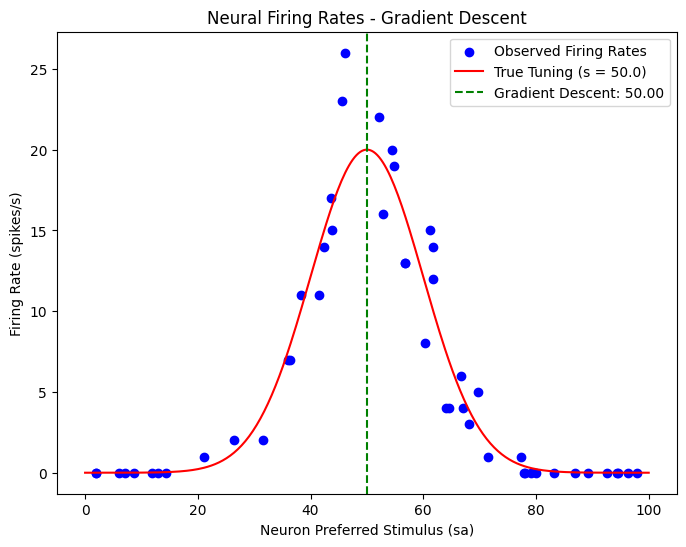

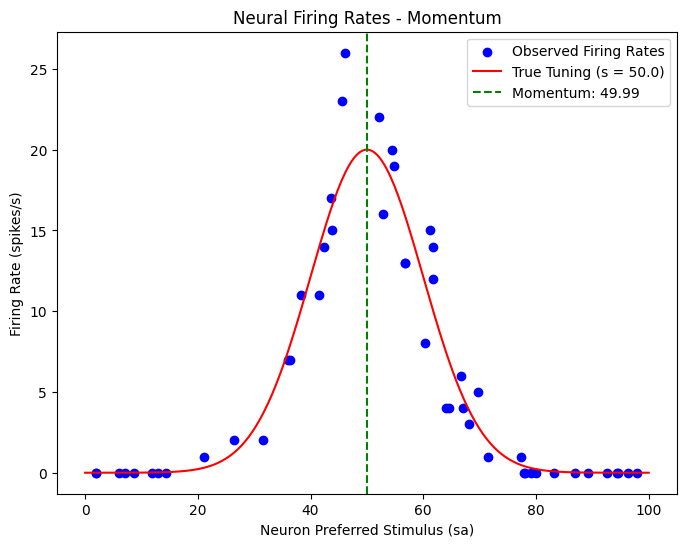

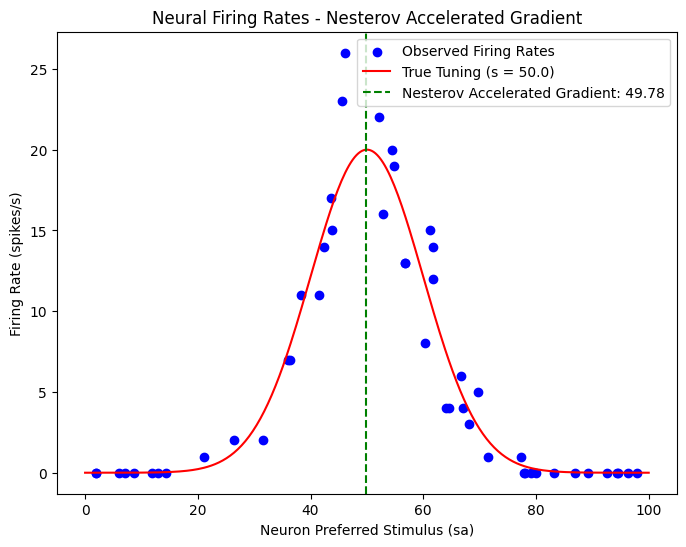

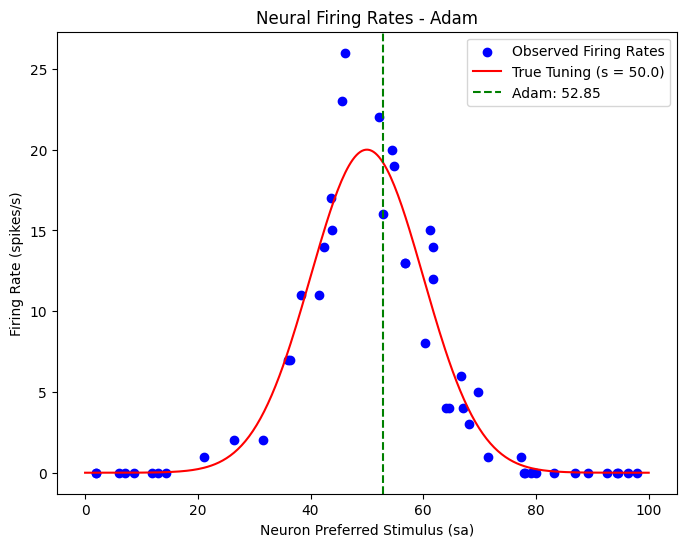

In [ ]:
learning_rate = 0.001
epochs = 1000

s_gd = optimize_gradient_descent(learning_rate, epochs)
s_momentum = optimize_momentum(learning_rate, epochs)
s_nesterov = optimize_nesterov(learning_rate, epochs)
s_adam = optimize_adam(learning_rate, epochs)

optimizers = {
    "Gradient Descent": s_gd,
    "Momentum": s_momentum,
    "Nesterov Accelerated Gradient": s_nesterov,
    "Adam": s_adam
}

for optimizer_name, s_opt in optimizers.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(sa_values, r_values, color='blue', label='Observed Firing Rates')

    sa_plot = np.linspace(0, 100, 300)
    true_curve = [gaussian_tuning_curve(s_true, sa, sigma, R_max) for sa in sa_plot]
    plt.plot(sa_plot, true_curve, color='red', label=f'True Tuning (s = {s_true})')

    plt.axvline(s_opt, color='green', linestyle='dashed', label=f'{optimizer_name}: {s_opt:.2f}')

    plt.xlabel('Neuron Preferred Stimulus (sa)')
    plt.ylabel('Firing Rate (spikes/s)')
    plt.title(f'Neural Firing Rates - {optimizer_name}')
    plt.legend()
    plt.show()
